In [1]:
import numpy as np
import bisect
import matplotlib.pyplot as plt

# Paso 1: Constantes físicos en unidades CGS

In [29]:
c = 2.99792458e10 # velocidad de luz, cm/s
h = 6.6260755e-27 # constante de Planck, erg*s
G = 6.67259e-8 # constante de gravitacion, cm^3/g/s
e = 4.8032068e-10 # cargar del electron, esu
me = 9.1093897e-28 # masa del electron, g
mB = 1.66057e-24 # masa del baryon, g
Msol = 1.99e33 # masa del sol, g
Rsol = 6.96e10 # radio del sol, cm
km = 1e5 # cm

# Paso 2: Ecuación de Estado

Necesitaremos resolver ecuaciones parametricos para describir materia densa en los siguientes celulos. Por eso, necesitamos desarrollar un metodo para interpolar una funcion probado en varios lugares.

In [30]:
# xEn - x donde queremos obtener un valor d y
# xCuadricula - un array de valores de x
# yCuadricula - un array de valores de y en los lugares x
def interpolar(xEn, xCuadricula, yCuadricula):
    # get the upper indes
    i = bisect.bisect_right(xCuadricula, xEn, lo=0, hi=len(xCuadricula))

    # check for degenerate case
    yDerecha    = yCuadricula[i  ];
    xDerecha    = xCuadricula[i  ];
    yIzquierda  = yCuadricula[i-1];
    xIzquierda  = xCuadricula[i-1];
    if(yDerecha == yIzquierda):
        return yDerecha;

    # do the interpolation
    inclinacion = (yDerecha-yIzquierda) / (xDerecha-xIzquierda);
    ySalida = yIzquierda + (xEn-xIzquierda)*inclinacion;
    return ySalida;

yPrueba = 0.12962962962962965


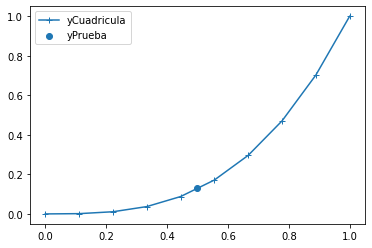

In [31]:
xCuadricula = np.linspace(0,1,10)
yCuadricula = xCuadricula**3
xPrueba = 0.5
yPrueba = interpolar(xPrueba, xCuadricula, yCuadricula)
plt.plot(xCuadricula, yCuadricula,marker="+",label="yCuadricula")
plt.scatter(xPrueba,yPrueba, label="yPrueba")
plt.legend()
print("yPrueba =", yPrueba)

Equation of state class

In [32]:
class EDE:
    def __init__(self, DensidadDeMasaMin, DensidadDeMasaMax, npoints):
        # crear array de densidad de masa
        log10DensidadDeMasaMin = np.log10(DensidadDeMasaMin)
        log10DensidadDeMasaMax = np.log10(DensidadDeMasaMax)
        dlog10DensidadDeMasa = (log10DensidadDeMasaMax - log10DensidadDeMasaMin) / (npoints-1)
        self.log10DensidadDeMasa = np.array([log10DensidadDeMasaMin + i*dlog10DensidadDeMasa for i in range(npoints)])
        DensidadDeMasa = 10**self.log10DensidadDeMasa # g/ccm

        # definir constantes para ecuacion 13 de Oppenheimer
        K = np.pi*mB**4*c**5 / (4.*h**3); # erg/ccm 
        
        # crear array de t, presion, densidad de energia
        phat = (DensidadDeMasa/mB * 3.*h**3/(8.*np.pi))**(1./3.) / (mB*c)
        t = 4. * np.log(phat + np.sqrt(1.+phat*phat))
        DensidadTotal = K    * (np.sinh(t) - t) # erg/ccm
        Presion       = K/3. * (np.sinh(t) - 8.*np.sinh(t/2.) + 3.*t) # erg/ccm
        DensidadDeEnergia = DensidadTotal - DensidadDeMasa*c**2 # erg/ccm

        # crear arrays logaritmicos para interpolacion
        self.log10DensidadDeMasa    = np.log10(DensidadDeMasa)
        self.log10Presion           = np.log10(Presion)
        self.log10DensidadDeEnergia = np.log10(DensidadDeEnergia)

    def calcPresion(self,DensidadDeMasa): # erg/ccm
        x = np.log10(DensidadDeMasa)
        xgrid = self.log10DensidadDeMasa
        ygrid = self.log10Presion
        return 10**interpolar(x, xgrid, ygrid)
        
    def calcDensidadDeMasa(self,Presion): # g/ccm
        x = np.log10(Presion)
        xgrid = self.log10Presion
        ygrid = self.log10DensidadDeMasa
        return 10**interpolar(x, xgrid, ygrid)

    def calcDensidadDeEnergia(self, Presion): # erg/ccm
        x = np.log10(Presion)
        xgrid = self.log10Presion
        ygrid = self.log10DensidadDeEnergia
        return 10**interpolar(x, xgrid, ygrid)
    
    def calcDensidadTotal(self, Presion): # g/ccm
        return self.calcDensidadDeEnergia(Presion)/c**2 + self.calcDensidadDeMasa(Presion)

Haciendo una ecuacion de estado basado en presion de degeneracion de neutrones.

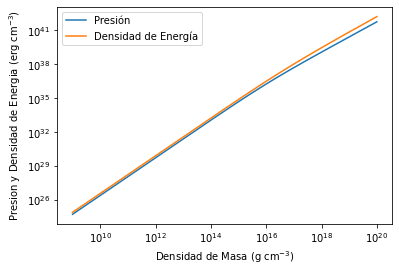

In [57]:
# inicializar la ecuacion de estadio.
# Solo nos importan las densidades entre 1e10 y 1e16 g/ccm,
# pero usamos un alcance mas grande para ver como queda.
# Calcular 200 puntas, entre de la clase EDE interpola.
ede = EDE(1e9, 1e20, 200)

# Hacer un grafico que mostra la ecuacion de estado
pres,  = plt.loglog(10**ede.log10DensidadDeMasa, 10**ede.log10Presion, label="Presión")
edens, = plt.loglog(10**ede.log10DensidadDeMasa, 10**ede.log10DensidadDeEnergia, label="Densidad de Energía")

# dibujar la leyenda
plt.legend()

# dibujar las etiquas de eje
plt.xlabel("Densidad de Masa (g cm$^{-3}$)")
plt.ylabel("Presion y Densidad de Energia (erg cm$^{-3}$)")
plt.show()

Equations of stellar structure

Papel de Oppenheimer y Volkoff:

https://journals.aps.org/pr/pdf/10.1103/PhysRev.55.374

In [34]:
def dPresion_dr(r, DensidadTotal, Presion, MasaTotalInterna): # cm, g/ccm, erg/ccm, g
    result =  -G*MasaTotalInterna/r**2 * (DensidadTotal + Presion/c**2) * (1.0 + 4.*np.pi*Presion*r**3/(MasaTotalInterna*c**2)) / (1. - 2.*G*MasaTotalInterna/(r*c**2))
    return result # erg/ccm/cm
    
def dMasaTotalInterna_dr(r, DensidadTotal): # cm, g/ccm
    return 4.*np.pi*r**2 * DensidadTotal # g

Verify that we have calculated the derivatives properly

In [35]:
r = 1e5 # cm
DensidadDeMasa = 1e12 # g/ccm
Presion = ede.calcPresion(DensidadDeMasa) # erg/ccm
MasaTotalInterna = 1e33 # g

print("dPresion_dr esperado: ", 1.3770551299991524e+28)
print("dPresion_dr calculado: ", dPresion_dr(r, DensidadDeMasa, Presion, MasaTotalInterna))
print()
print("dMasaTotalInterna_dr esperado: ", 1.25663706144e+23)
print("dMasaTotalInterna_dr calculado: ",dMasaTotalInterna_dr(r, DensidadDeMasa))

dPresion_dr esperado:  1.3770551299991524e+28
dPresion_dr calculado:  1.3770551299991524e+28

dMasaTotalInterna_dr esperado:  1.25663706144e+23
dMasaTotalInterna_dr calculado:  1.2566370614359172e+23


In [48]:
# RK2 Integrador
def integrar_FE(r0, Presion0, MasaTotalInterna0, dr, ede):

    DensidadTotal0 = ede.calcDensidadTotal(Presion0)
    
    # paso 1 - haz medio paso usando numeros iniciales
    dPdr =          dPresion_dr(r0, DensidadTotal0, Presion0, MasaTotalInterna0)
    dMdr = dMasaTotalInterna_dr(r0, DensidadTotal0)

    r1 = r0 + dr
    Presion1          =          Presion0 + dPdr*dr
    MasaTotalInterna1 = MasaTotalInterna0 + dMdr*dr

    return r1, Presion1, MasaTotalInterna1

In [51]:
def calcularRadioYMasa(dr, DensidadDeMasaAlCentro, DensidadDeMasa_parar, ede, imprimir=False):
    # condiciones iniciales (al centro de la estrella)
    r = dr
    DensidadDeMasa = DensidadDeMasaAlCentro
    Presion = ede.calcPresion(DensidadDeMasa) # erg/ccm
    DensidadTotal = ede.calcDensidadTotal(Presion) # g/ccm
    MasaTotalInterna = 4./3. * np.pi * r**3 * DensidadTotal # g
    
    # hacer pasos hasta la densidad de masa esta demasiado pequeno
    i=0
    while DensidadDeMasa > DensidadDeMasa_parar:
        r, Presion, MasaTotalInterna = integrar_FE(r, Presion, MasaTotalInterna, dr, ede)
        DensidadDeMasa = ede.calcDensidadDeMasa(Presion)
        
        # imprimir el radio (km), la densidad de masa (g/ccm), y la masa total interna (g)
        if imprimir and i%1000==0:
            print(str(i)+"\t"+str(r/km)+"\t"+str(DensidadDeMasa)+"\t"+str(MasaTotalInterna/Msol))
        i = i+1
    if imprimir:
        print(str(i)+"\t"+str(r/km)+"\t"+str(DensidadDeMasa)+"\t"+str(MasaTotalInterna/Msol))
        
    return r, MasaTotalInterna

In [54]:
print("Paso   Radio(km)   DensidadDeMasa(g/ccm)   MasaTotalInterna(Msol)")

# constantes que determinan la caulidad de la calculacion
dr = 10 # cm
DensidadDeMasa_parar = 1e10

# Tratar de calcular la masa y radio de solo una estrella de neutrones
DensidadDeMasaAlCentro = 1e15
R, M = calcularRadioYMasa(dr, DensidadDeMasaAlCentro, DensidadDeMasa_parar, ede, True)

Paso   Radio(km)   DensidadDeMasa(g/ccm)   MasaTotalInterna(Msol)
0	0.0002	999999999501047.2	9.1553247979392e-15
1000	0.1002	999750447676359.6	2.29878465981891e-06
2000	0.2002	999002353742313.6	1.834034158110653e-05
3000	0.3002	997756789277418.1	6.18036619240647e-05
4000	0.4002	996015540466355.8	0.00014628156279394473
5000	0.5002	993781102802227.0	0.0002852380315238094
6000	0.6002	991056675631572.2	0.0004919660698158282
7000	0.7002	987846155179875.1	0.0007795462007722598
8000	0.8002	984154126060423.1	0.001160805798756084
9000	0.9002	979985851282826.1	0.0016482793981959587
10000	1.0002	975347260782298.0	0.002254170132899426
11000	1.1002	970244938494614.9	0.0029903124521839844
12000	1.2002	964686108005239.6	0.003868136254202363
13000	1.3002	958678616804472.0	0.004898632570255126
14000	1.4002	952230919184012.2	0.006092320926681828
15000	1.5002	945352057814068.6	0.007459218503136566
16000	1.6002	938051644043135.0	0.009008811197723452
17000	1.7002	930346073302754.9	0.010750028660257913
1800

######################################################
# 5 - Calculando las Estructuras de Muchas Estrellas #
######################################################

DensidadDeMasaAlCentro(g/ccm)   Radio(km)   Masa(Msol)
100000000000000.12 20.8438 0.3122007185953981
115139539932644.64 20.293 0.3305360528871063
132571136559011.48 19.7504 0.34953507294450326
152641796717523.7 19.2157 0.36915638973379156
175751062485479.22 18.6887 0.38934670076594363
202358964772515.34 18.1691 0.41003978742742636
232995181051537.97 17.6569 0.4311533094706766
268269579527972.9 17.1518 0.45259440033045656
308884359647747.9 16.6538 0.4742538522096474
355648030622314.44 16.1626 0.49600737091286623
409491506238043.44 15.6784 0.5177160657156247
471486636345739.44 15.201 0.5392272222145924
542867543932385.0 14.7304 0.5603756234978973
625055192527399.4 14.2668 0.5809854240892275
719685673001152.9 13.8103 0.6008726037302283
828642772854683.8 13.3611 0.6198453415526262
954095476349998.0 12.9194 0.6377138923382898
1

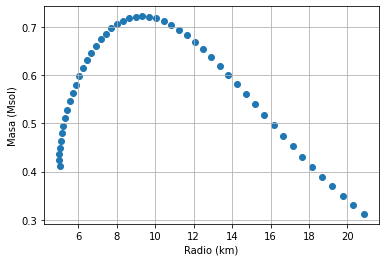

In [55]:
print("######################################################")
print("# 5 - Calculando las Estructuras de Muchas Estrellas #")
print("######################################################")
print()
print("DensidadDeMasaAlCentro(g/ccm)   Radio(km)   Masa(Msol)")

# Calcula la masa y radio de muchos estrellas de neutrinos y hacer un grafico
DensidadDeMasaAlCentro0 = 1e14 # g/ccm
DensidadDeMasaAlCentro1 = 1e17 # g/ccm
NumeroDeEstrellas = 50
DensidadesALosCentros = np.exp(np.linspace(np.log(DensidadDeMasaAlCentro0), np.log(DensidadDeMasaAlCentro1), NumeroDeEstrellas))
ListaDeR = []
ListaDeM = []
for iEstrella in range(NumeroDeEstrellas):
    DensidadDeMasaAlCentro = DensidadesALosCentros[iEstrella]
    R,M = calcularRadioYMasa(dr, DensidadDeMasaAlCentro, DensidadDeMasa_parar, ede, False)
    ListaDeR.append(R/km)
    ListaDeM.append(M/Msol)
    print(DensidadDeMasaAlCentro, R/km, M/Msol)
plt.grid()
plt.xlabel("Radio (km)")
plt.ylabel("Masa (Msol)")
plt.scatter(ListaDeR, ListaDeM)